## Imports

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import int64
import seaborn as sns
from functions import num_to_years
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm
pd.set_option('display.max_columns', 100)
import missingno as msno
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC


In [2]:
y = pd.read_csv('credit_record.csv')
X = pd.read_csv('application_record.csv')

In [3]:
X.columns = [i.lower() for i in X.columns]
y.columns = [i.lower() for i in y.columns]

In [4]:
X.groupby('id')['id'].count(), y.groupby('id')['id'].count()

(id
 5008804    1
 5008805    1
 5008806    1
 5008808    1
 5008809    1
           ..
 7999660    1
 7999696    1
 7999738    1
 7999784    1
 7999952    1
 Name: id, Length: 438510, dtype: int64,
 id
 5001711     4
 5001712    19
 5001713    22
 5001714    15
 5001715    60
            ..
 5150482    18
 5150483    18
 5150484    13
 5150485     2
 5150487    30
 Name: id, Length: 45985, dtype: int64)

We can see that there are 438510 unique ids in X dataframe and 45985 unique ids on y dataframe.   
We want to get the intersection between the ids of X and y

In [5]:
X = X.merge(y, how='inner', on='id')

In [6]:
y['id'] = X.id
y['months_balance'] = X.months_balance
y.status = X.status

## Exporation

In [7]:
X.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [8]:
X.describe()

,id,cnt_children,amt_income_total,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,cnt_fam_members,months_balance
count,7.777150e+05,777715.000000,7.777150e+05,777715.000000,777715.000000,777715.0,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000
mean,5.078743e+06,0.428082,1.885348e+05,-16124.937046,57775.825016,1.0,0.231818,0.300965,0.091675,2.208837,-19.373564
std,4.180442e+04,0.745755,1.016225e+05,4104.304018,136471.735391,0.0,0.421993,0.458678,0.288567,0.907380,14.082208
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.044568e+06,0.000000,1.215000e+05,-19453.000000,-3292.000000,1.0,0.000000,0.000000,0.000000,2.000000,-29.000000
50%,5.069530e+06,0.000000,1.620000e+05,-15760.000000,-1682.000000,1.0,0.000000,0.000000,0.000000,2.000000,-17.000000
75%,5.115551e+06,1.000000,2.250000e+05,-12716.000000,-431.000000,1.0,0.000000,1.000000,0.000000,3.000000,-8.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


## Tyding the data

We want to have the client's age and job seniority in years instead of days

In [9]:
def num_to_years(num):
    try:
        if num < 0:
            year = num/-365
        else:
            year = 0
    except:
        return None
    return year

In [10]:
def days_to_years(X):
    X['age'] = X['days_birth'].apply(num_to_years)
    X.drop('days_birth', axis=1)
    X['job_seniority'] = X['days_employed'].apply(num_to_years)
    X.drop('days_employed', axis=1)
    return X

In [11]:
y = y[~(y['status'].isnull())]

I want to format all status value with an inteager value, that way we can fit the values into a model

In [12]:
def status_int(s):
    if s=='C':
        return -1
    if s=='X':
        return -2
    else:
        return int(s)

y['status'] = y['status'].apply(status_int)

In [13]:
X = days_to_years(X)
X['status'] = X['status'].apply(status_int)
X = X.drop(['days_birth', 'days_employed'], axis=1)
X = X[X['job_seniority'] >=0]
X.describe()

,id,cnt_children,amt_income_total,flag_mobil,flag_work_phone,flag_phone,flag_email,cnt_fam_members,months_balance,status,age,job_seniority
count,7.777150e+05,777715.000000,7.777150e+05,777715.0,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000
mean,5.078743e+06,0.428082,1.885348e+05,1.0,0.231818,0.300965,0.091675,2.208837,-19.373564,-0.773726,44.177910,6.368327
std,4.180442e+04,0.745755,1.016225e+05,0.0,0.421993,0.458678,0.288567,0.907380,14.082208,0.804922,11.244669,6.684401
min,5.008804e+06,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,-2.000000,20.517808,0.000000
25%,5.044568e+06,0.000000,1.215000e+05,1.0,0.000000,0.000000,0.000000,2.000000,-29.000000,-1.000000,34.838356,1.180822
50%,5.069530e+06,0.000000,1.620000e+05,1.0,0.000000,0.000000,0.000000,2.000000,-17.000000,-1.000000,43.178082,4.608219
75%,5.115551e+06,1.000000,2.250000e+05,1.0,0.000000,1.000000,0.000000,3.000000,-8.000000,0.000000,53.295890,9.019178
max,5.150487e+06,19.000000,1.575000e+06,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,5.000000,68.909589,43.049315


We want to replace coded features to binary values:

In [14]:
def binary_gender(s):
    if s=='F':
        return 1
    if s=='M':
        return 0

X['code_gender'] = X['code_gender'].apply(binary_gender)

In [15]:
def binary_car(s):
    if s=='Y':
        return 1
    if s=='N':
        return 0

X['flag_own_car'] = X['flag_own_car'].apply(binary_car)
X['flag_own_realty'] = X['flag_own_realty'].apply(binary_car)

## Visualiztion

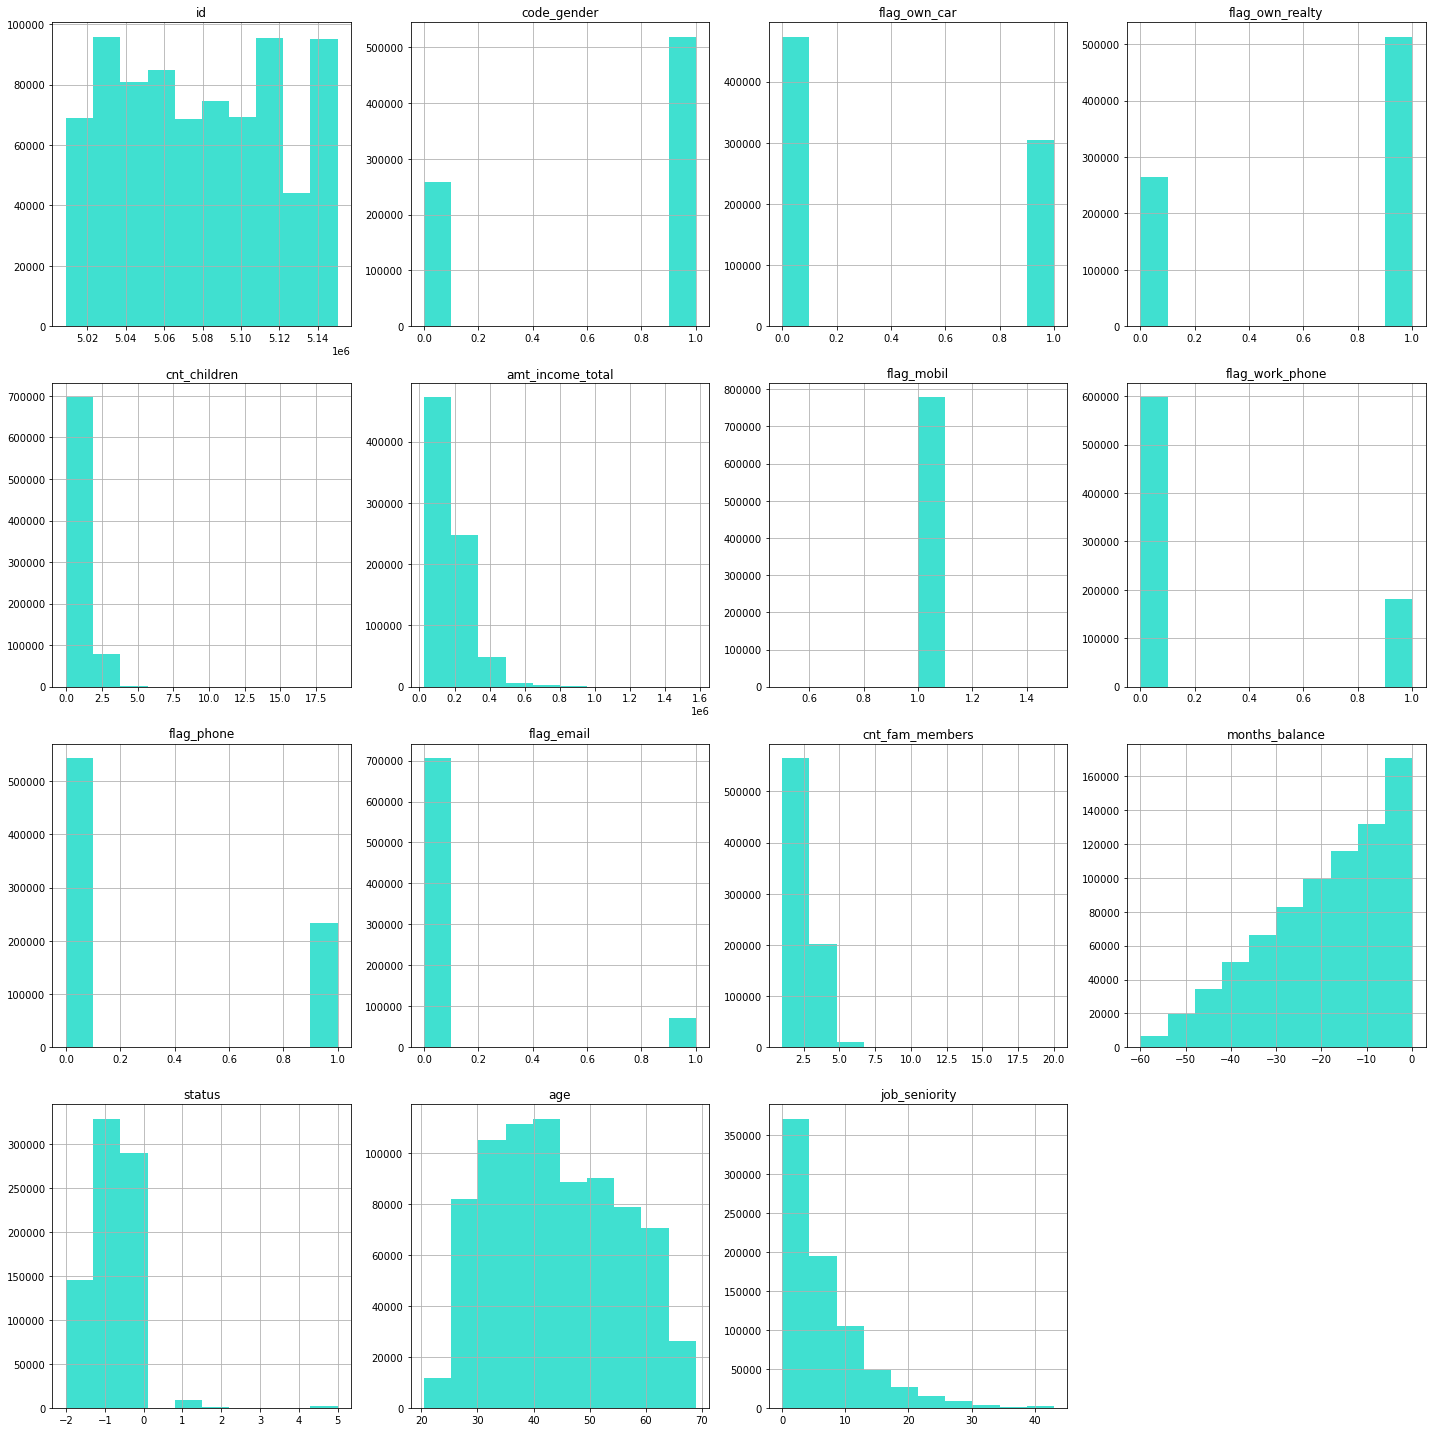

In [16]:
X.hist(figsize=(20,20), bins=10, color='turquoise')
plt.tight_layout()
plt.show()

In [17]:
#seems like all clients has a mobile phone
X.drop('flag_mobil', axis = 1, inplace = True)

In [18]:
values_count = X['name_family_status'].value_counts()

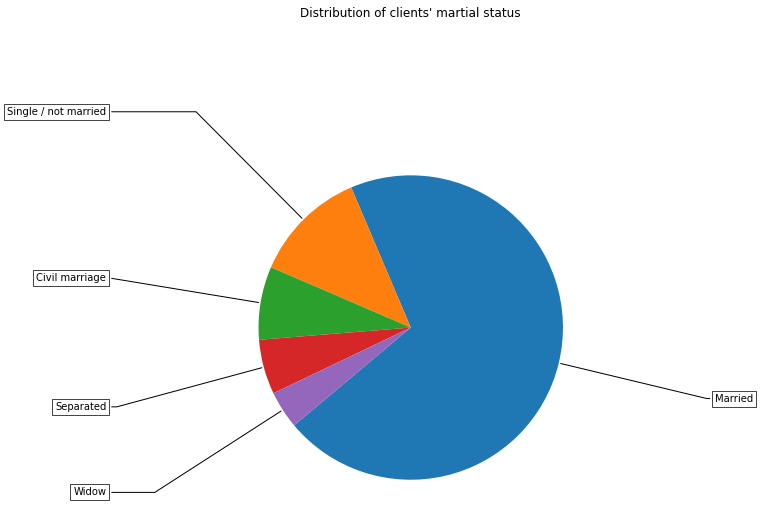

In [19]:
fig, ax = plt.subplots(figsize=(15, 7), subplot_kw=dict(aspect="equal"))

recipe = values_count.index.tolist()


data = values_count




#When you change the width to 0.5 you get a donut chart

wedges, texts = ax.pie(data, wedgeprops=dict(width=1), startangle=-140)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    z = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, z), xytext=(2*np.sign(x), 2*z),
                horizontalalignment=horizontalalignment, **kw)

plt.title("Distribution of clients' martial status", y= 1.3)

plt.show()

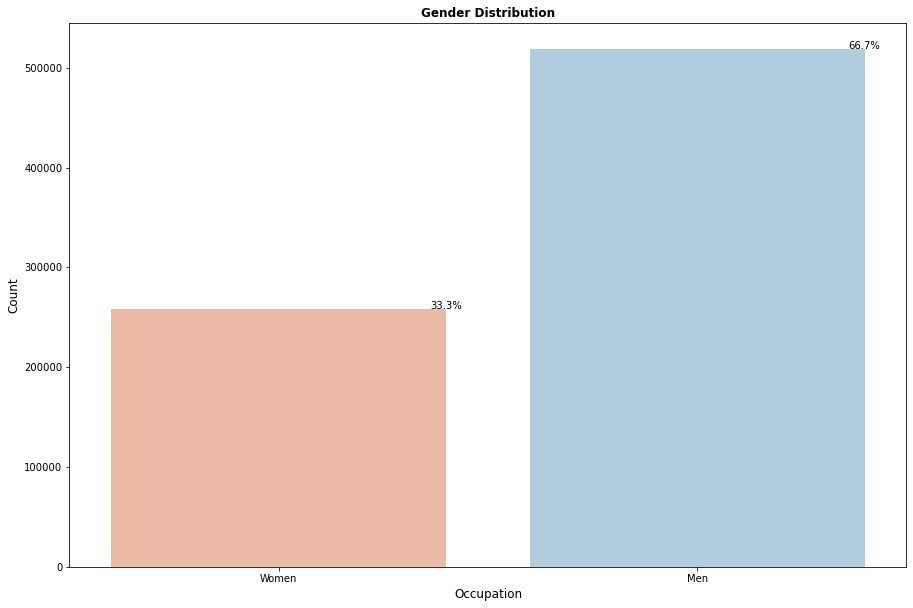

In [20]:
fig, ax = plt.subplots(figsize = (15,10))
bar = sns.countplot(x='code_gender' ,data=X, palette="RdBu")
plt.xticks([0,1], ['Women','Men' ])
total = float(len(y))
for p in bar.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x1 = p.get_x() + p.get_width()
    y1 = p.get_height()
    bar.annotate(percentage, (x1, y1),ha='center')
plt.title('Gender Distribution', weight='bold')
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

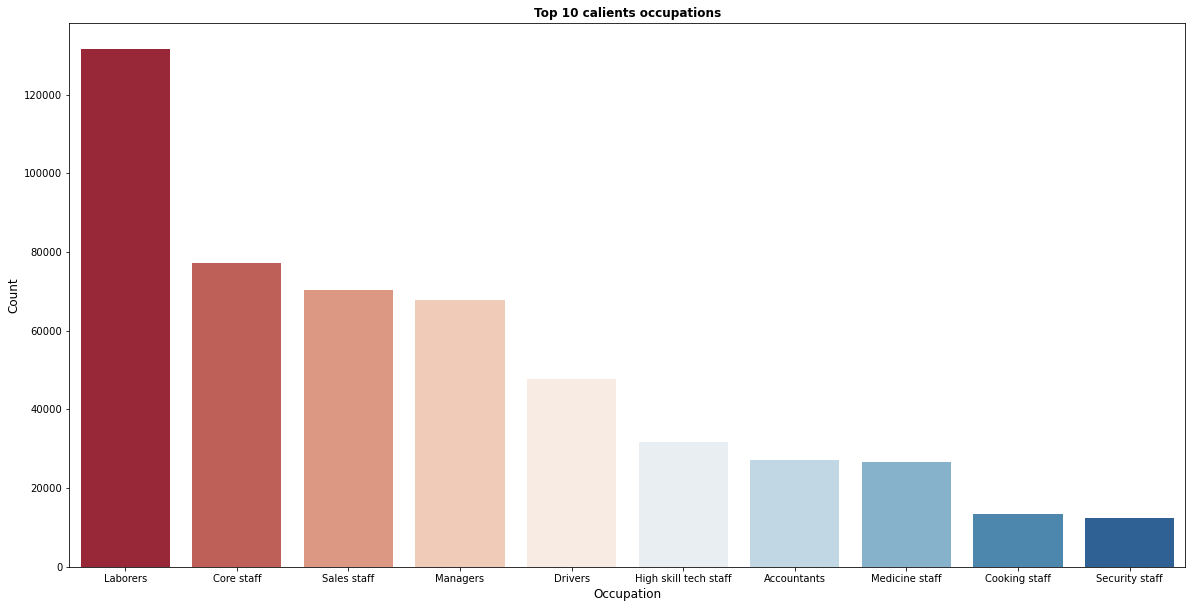

In [21]:
fig, bar = plt.subplots(figsize = (20,10))
fig
sns.countplot(x='occupation_type' ,data=X,
              order=pd.value_counts(X['occupation_type']).iloc[:10].index, palette="RdBu")
plt.title('Top 10 calients occupations', weight='bold')
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

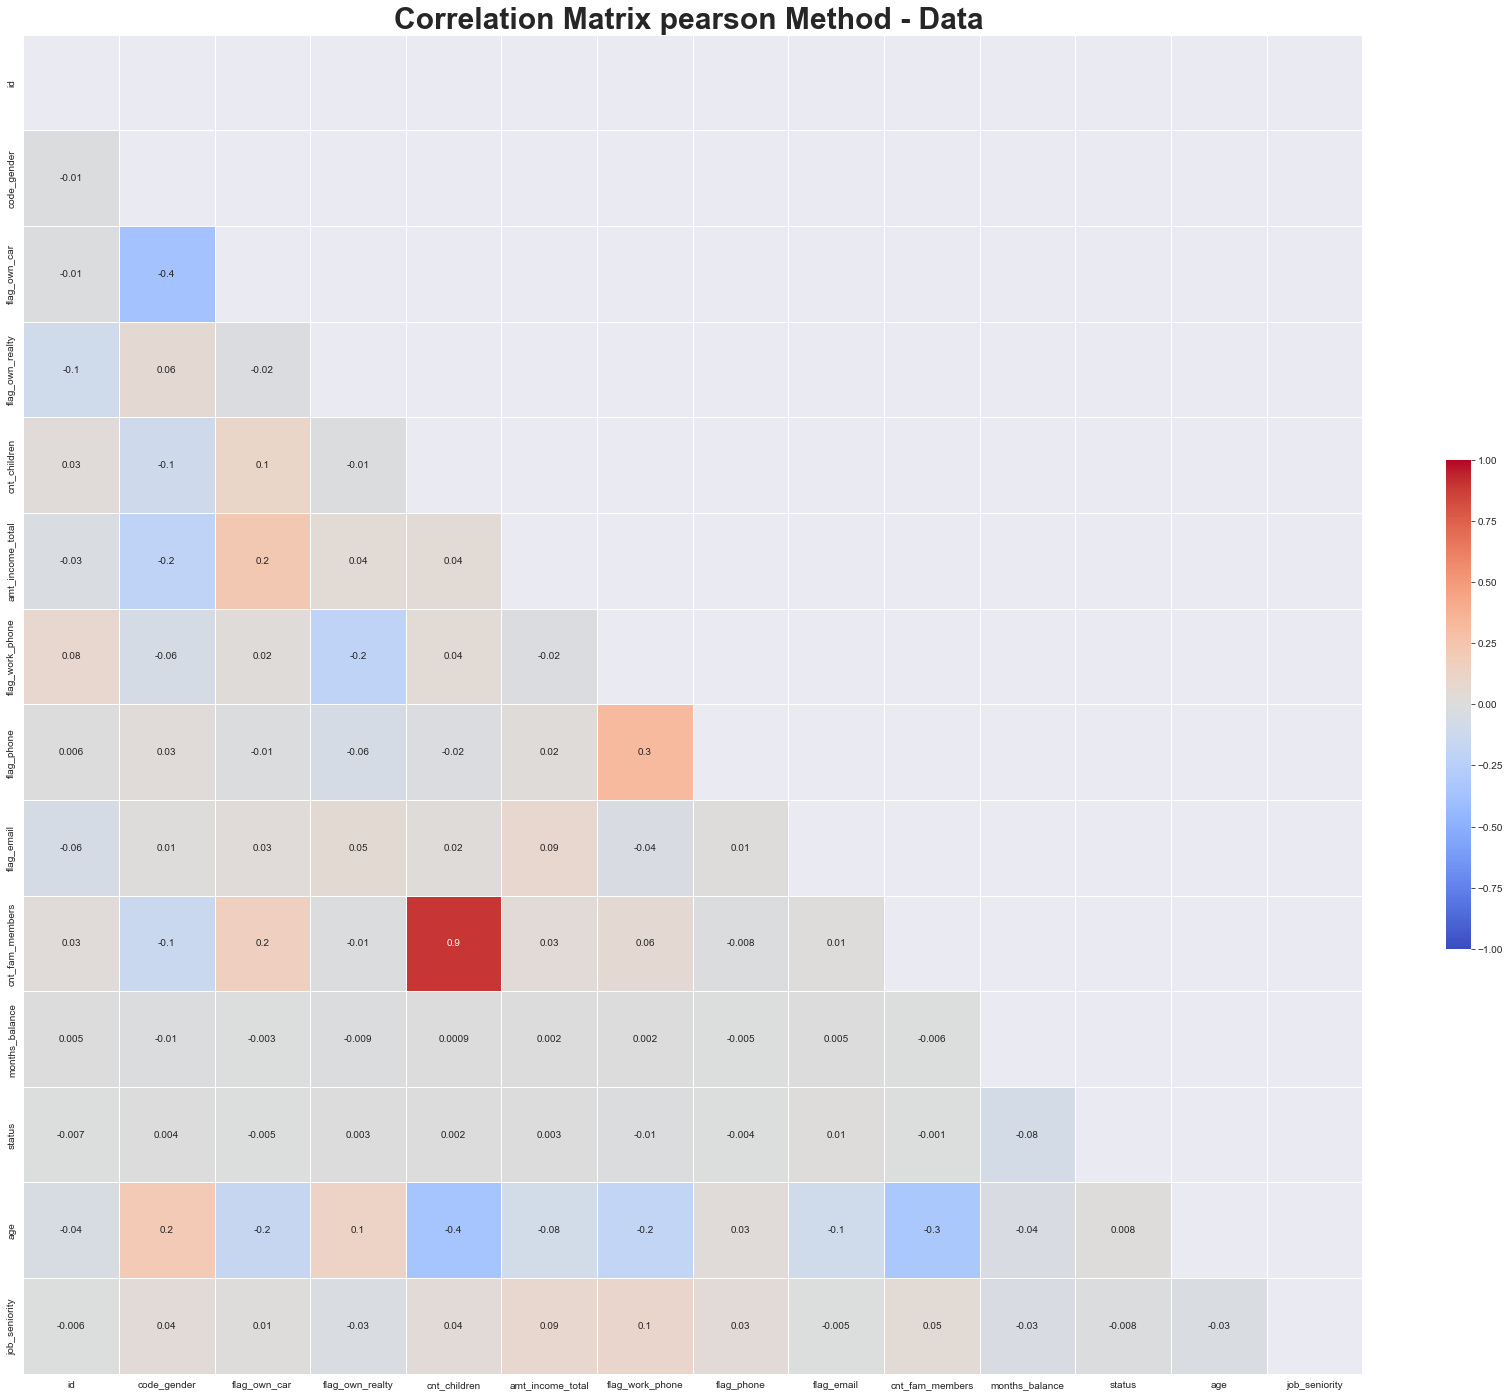

In [22]:
plt.figure(figsize=(30,30))
sns.set_style('darkgrid')
corr=X.corr(method='pearson')
mask_corr = np.triu(np.ones_like(corr, dtype=bool))
heat = sns.heatmap(corr, square=True,
            annot=True, fmt='.1g', linewidths=0.5,
            linecolor='white', cmap= 'coolwarm', mask=mask_corr,
            vmin=-1, vmax=1, cbar_kws={'shrink': 0.3},
            annot_kws={"fontsize":10},)
plt.title("Correlation Matrix pearson Method - Data ",size=30, weight='bold')
plt.show()

we can see that the correlations between the features are neutral, except for the obvious positive correlation berween family members number and number of kids 

Text(0.5, 1.0, "Clients' Loan Status for Current Month")

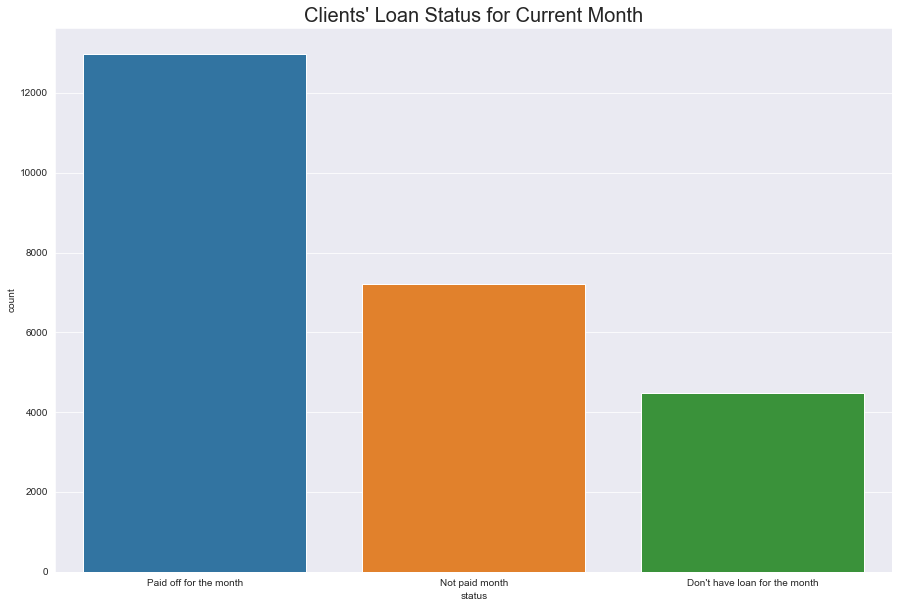

In [23]:
def is_paid(num):
    if num == -2:
        return "Don't have loan for the month"
    if num == -1:
        return 'Paid off for the month'
    else:
        return 'Not paid month'
        
paying_series = X[X.months_balance == 0]['status'].apply(is_paid)

fig, bar = plt.subplots(figsize = (15,10))
sns.countplot(x = paying_series)
plt.title("Clients' Loan Status for Current Month", size =20)

<BarContainer object of 5 artists>

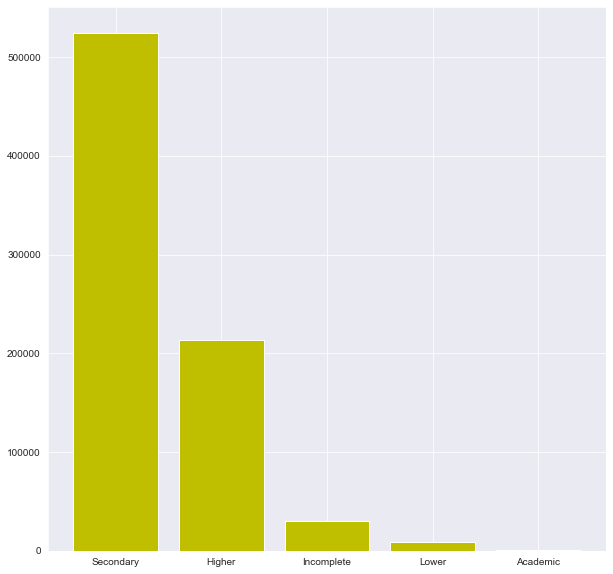

In [24]:
#let's filter all closed loans
open_loans = X[~(X['status'] < -1)]

plt.figure(figsize = (10,10))
plt.bar(x = [i.split()[0] for i in X['name_education_type'].value_counts().index.tolist()], height =  X['name_education_type'].value_counts(), color = 'y')

<AxesSubplot:title={'center':'amt_income_total'}, xlabel='name_education_type'>

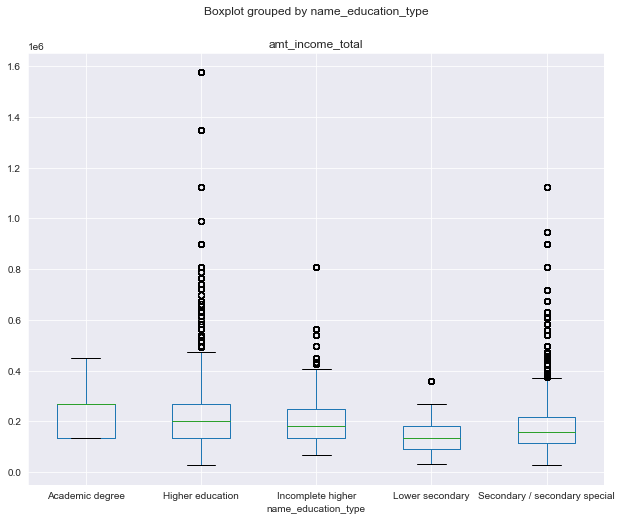

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
X.boxplot(column=['amt_income_total'], by='name_education_type', ax=ax)

## Preprocessing

In [26]:
#let's split X and y df, we want to keep month_recorded as a feature that will help us predict 
X.drop(columns = ['status'])

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,age,job_seniority
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2.0,0,32.890411,12.443836
1,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2.0,-1,32.890411,12.443836
2,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2.0,-2,32.890411,12.443836
3,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2.0,-3,32.890411,12.443836
4,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2.0,-4,32.890411,12.443836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777710,5150337,0,0,1,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,0,0,0,Laborers,1.0,-9,25.172603,3.268493
777711,5150337,0,0,1,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,0,0,0,Laborers,1.0,-10,25.172603,3.268493
777712,5150337,0,0,1,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,0,0,0,Laborers,1.0,-11,25.172603,3.268493
777713,5150337,0,0,1,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,0,0,0,Laborers,1.0,-12,25.172603,3.268493


In [27]:
#check if there are any missing values
print(X.shape)

X.isna().sum()

(777715, 19)


id                          0
code_gender                 0
flag_own_car                0
flag_own_realty             0
cnt_children                0
amt_income_total            0
name_income_type            0
name_education_type         0
name_family_status          0
name_housing_type           0
flag_work_phone             0
flag_phone                  0
flag_email                  0
occupation_type        240048
cnt_fam_members             0
months_balance              0
status                      0
age                         0
job_seniority               0
dtype: int64

we can see that the only column that has missing values is occupation_type 
I want to understand if there is a major difference between 

We can see that whether the occupation type is null or not doesn't change much about the mean status value

In [28]:
X.groupby('occupation_type').agg('mean')

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,flag_work_phone,flag_phone,flag_email,cnt_fam_members,months_balance,status,age,job_seniority
occupation_type,,,,,,,,,,,,,,
Accountants,5.084152e+06,0.976086,0.386915,0.632517,0.462624,207761.509661,0.295375,0.344047,0.127356,2.239430,-19.482386,-0.801308,42.112164,7.368922
Cleaning staff,5.075761e+06,0.954908,0.111062,0.695500,0.347487,149095.947013,0.346346,0.277305,0.050794,1.934731,-18.878586,-0.747522,49.072388,7.047043
Cooking staff,5.074418e+06,0.894454,0.206023,0.628503,0.358154,144189.411896,0.240385,0.282126,0.074761,2.163760,-19.443798,-0.750075,41.491278,6.702092
Core staff,5.078680e+06,0.798669,0.378644,0.655255,0.600179,191917.622899,0.293690,0.308344,0.129980,2.372847,-19.406668,-0.784015,39.289373,8.286733
Drivers,5.076587e+06,0.059776,0.741453,0.598117,0.570808,208968.926968,0.292630,0.295818,0.090755,2.443391,-19.331222,-0.793238,41.221064,5.624932
HR staff,5.075306e+06,0.851127,0.438316,0.420522,0.402728,196705.516014,0.138197,0.298932,0.169632,1.959668,-20.479241,-0.581851,38.970302,5.746023
High skill tech staff,5.079165e+06,0.689216,0.462509,0.644076,0.508310,197953.892282,0.287931,0.390708,0.130194,2.308896,-19.585023,-0.787554,41.786829,8.998893
IT staff,5.098527e+06,0.460197,0.491281,0.507961,0.402578,223593.707354,0.108415,0.313116,0.218347,2.073541,-18.811979,-0.577710,36.432438,4.745104
Laborers,5.079365e+06,0.428685,0.431999,0.628432,0.489686,181708.198933,0.284019,0.277149,0.072021,2.282271,-19.139711,-0.790199,40.758324,7.859219


In [29]:
X[X.name_income_type =='Pensioner'].isna().sum()

id                          0
code_gender                 0
flag_own_car                0
flag_own_realty             0
cnt_children                0
amt_income_total            0
name_income_type            0
name_education_type         0
name_family_status          0
name_housing_type           0
flag_work_phone             0
flag_phone                  0
flag_email                  0
occupation_type        128060
cnt_fam_members             0
months_balance              0
status                      0
age                         0
job_seniority               0
dtype: int64

In [30]:
#we will first impute the null occupation type values by placing 'not working' whereas name_income_type is Pensioner
X.loc[X.name_income_type =='Pensioner','occupation_type'] = 'Unemployed'

In [31]:
X.isna().sum()

id                          0
code_gender                 0
flag_own_car                0
flag_own_realty             0
cnt_children                0
amt_income_total            0
name_income_type            0
name_education_type         0
name_family_status          0
name_housing_type           0
flag_work_phone             0
flag_phone                  0
flag_email                  0
occupation_type        111988
cnt_fam_members             0
months_balance              0
status                      0
age                         0
job_seniority               0
dtype: int64

In [32]:
X.loc[X['occupation_type'] == None] = 'Unknown'

we want to treat every month in the client's history as a feature

In [33]:
for x in range(-60,1):
    X["month_{0}".format(x)] = None

In [34]:
print(X.shape)
X.drop_duplicates("id", inplace = True, keep='first')
print(X.shape)

(777715, 80)
(36457, 80)


The following cell will take some time to run, as it iterate 777,715 rows

In [35]:
cur = y.iloc[0,0]
prev=0
i=-1
j=0
for index, row in y.iterrows():
    #this section was created to give us a quick access to the df
    cur = row.id
    if cur!=prev:
        prev = cur
        cur = row.id
        i +=1
        j=0
    X.iloc[i , 79-j] = int(row.status)
    j+=1
    if i%5000==0 and j==1:
        print("loaded ", i*100/len(X),"%")

loaded  0.0 %
loaded  13.71478728364923 %
loaded  27.42957456729846 %
loaded  41.14436185094769 %
loaded  54.85914913459692 %
loaded  68.57393641824615 %
loaded  82.28872370189538 %
loaded  96.00351098554461 %


In [36]:
X

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,age,job_seniority,month_-60,month_-59,month_-58,month_-57,month_-56,month_-55,month_-54,month_-53,month_-52,month_-51,month_-50,month_-49,month_-48,month_-47,month_-46,month_-45,month_-44,month_-43,month_-42,month_-41,month_-40,month_-39,month_-38,month_-37,month_-36,month_-35,month_-34,month_-33,month_-32,month_-31,month_-30,month_-29,month_-28,month_-27,month_-26,month_-25,month_-24,month_-23,month_-22,month_-21,month_-20,month_-19,month_-18,month_-17,month_-16,month_-15,month_-14,month_-13,month_-12,month_-11,month_-10,month_-9,month_-8,month_-7,month_-6,month_-5,month_-4,month_-3,month_-2,month_-1,month_0
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2.0,0,-1,32.890411,12.443836,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-2,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
16,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2.0,0,-1,32.890411,12.443836,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-2,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
31,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,0,-1,58.832877,3.106849,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-2,0,-2,-2,-2,0,-2,-2,-2,0,-2,-2,-2,-2,-2,-2,0,-2,0,-2,0,0,-2,-1,-1,-1,-1,-1,-1,-1
61,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,0,0,52.356164,8.358904,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-2,-2,0,-2,0
66,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,-22,-2,52.356164,8.358904,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-2,-2,-2,-2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777622,5149828,0,1,1,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Managers,2.0,0,5,47.528767,6.630137,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-2,-2,-2,-2,-2,-2,4,-2,-2,5,5,5
777634,5149834,1,0,1,0,157500.0,Commercial associate,Higher education,Married,House / apartment,0,1,1,Medicine staff,2.0,0,-1,33.936986,3.630137,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,N

In [37]:
data = [X["id"], X["month_0"]]

headers = ["id", "status"]

y = pd.concat(data, axis=1, keys=headers)


In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 777701
Data columns (total 80 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   36457 non-null  object
 1   code_gender          36457 non-null  object
 2   flag_own_car         36457 non-null  object
 3   flag_own_realty      36457 non-null  object
 4   cnt_children         36457 non-null  object
 5   amt_income_total     36457 non-null  object
 6   name_income_type     36457 non-null  object
 7   name_education_type  36457 non-null  object
 8   name_family_status   36457 non-null  object
 9   name_housing_type    36457 non-null  object
 10  flag_work_phone      36457 non-null  object
 11  flag_phone           36457 non-null  object
 12  flag_email           36457 non-null  object
 13  occupation_type      31273 non-null  object
 14  cnt_fam_members      36457 non-null  object
 15  months_balance       36457 non-null  object
 16  sta

C:\Users\PC\anaconda3\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\Users\PC\anaconda3\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


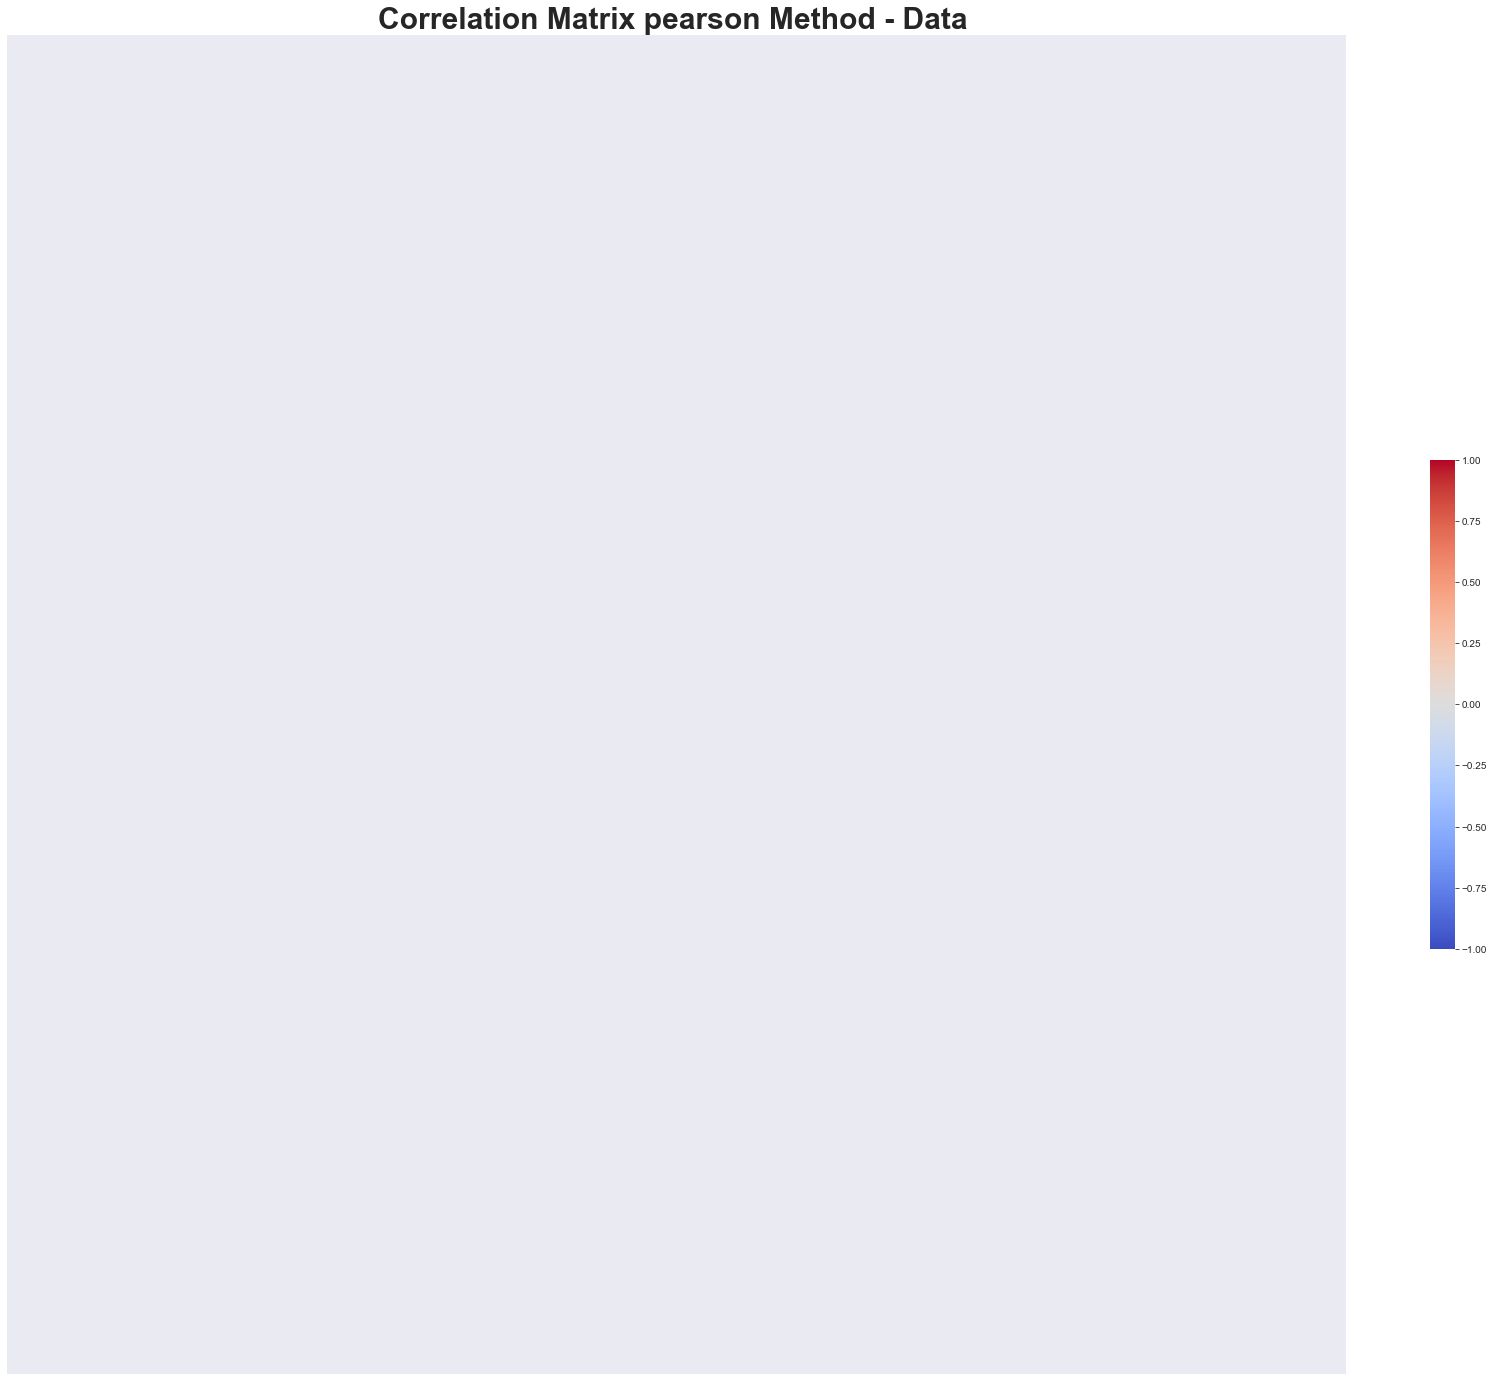

In [39]:
plt.figure(figsize=(30,30))
sns.set_style('darkgrid')
corr=X.corr(method='pearson')
mask_corr = np.triu(np.ones_like(corr, dtype=bool))
heat = sns.heatmap(corr, square=True,
            annot=True, fmt='.1g', linewidths=0.5,
            linecolor='white', cmap= 'coolwarm', mask=mask_corr,
            vmin=-1, vmax=1, cbar_kws={'shrink': 0.3},
            annot_kws={"fontsize":10},)
plt.title("Correlation Matrix pearson Method - Data ",size=30, weight='bold')
plt.show()

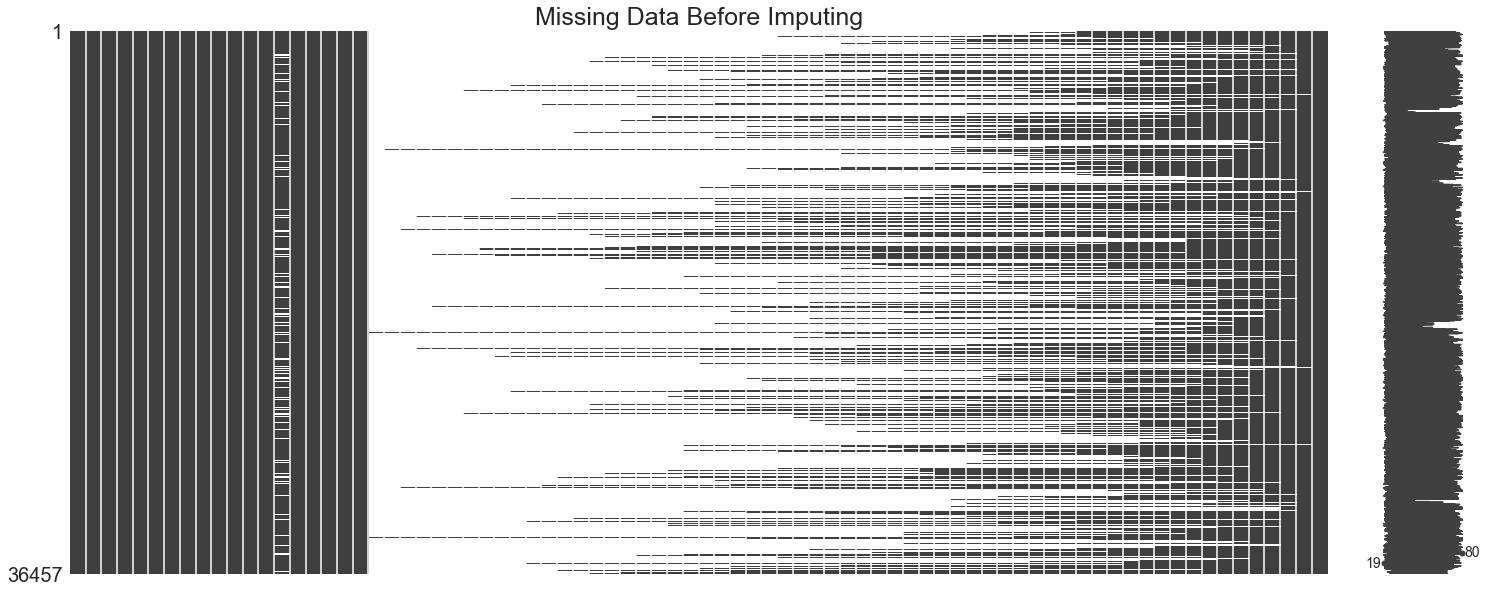

In [40]:
msno.matrix(X)
plt.title('Missing Data Before Imputing', fontsize=25)
plt.show()

In [41]:

null_lst = X.isnull().sum().divide(X.shape[0]).round(2).astype(str) + "%"
null_lst.sort_values(ascending = False)

month_-60           1.0%
month_-59          0.99%
month_-57          0.99%
month_-58          0.99%
month_-56          0.98%
                   ...  
cnt_fam_members     0.0%
months_balance      0.0%
status              0.0%
age                 0.0%
month_0             0.0%
Length: 80, dtype: object

In [42]:
for x in range(-60,-4):
    X.drop("month_{0}".format(x), axis = 1,inplace=True)

In [43]:
y['status'] = y['status'].apply(np.int64)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y['status'], test_size=0.33, random_state=42)

# Categorical feature encoding

In [45]:
for col in X_train.columns:
    if "type"  in col or "name" in col:
        for val, num in zip(X_train[col].value_counts().index.tolist(), X_train[col].value_counts(normalize=True)):
            if num<0.05:
                print(val, num)
                X_train.loc[X_train[col] == val,col]  = 'Other' 

Student 0.00024563989191844754
Incomplete higher 0.038974862851060346
Lower secondary 0.010316875460574797
Academic degree 0.0009006796037009743
Widow 0.04220912142798657
With parents 0.0475313190862196
Municipal apartment 0.030131826741996232
Rented apartment 0.01604847293867191
Office apartment 0.007246376811594203
Co-op apartment 0.004421518054532056
High skill tech staff 0.04478893393751491
Accountants 0.03887431433341283
Medicine staff 0.038015740519914146
Cooking staff 0.021082756975912234
Security staff 0.018316241354638683
Cleaning staff 0.01702838063439065
Private service staff 0.011399952301454805
Low-skill Laborers 0.005437634152158359
Waiters/barmen staff 0.005294538516575244
Secretaries 0.005008347245409015
HR staff 0.0027188170760791795
Realty agents 0.002337228714524207
IT staff 0.002146434533746721


C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [46]:
for col in X_train.columns:
    if "type"  in col or "name" in col:
        print("_____new_col______")
        for val, num in zip(X_train[col].value_counts().index.tolist(), X_train[col].value_counts(normalize=True)):
            print(val, num)

_____new_col______
Working 0.5149021534430525
Commercial associate 0.2323753377548514
Pensioner 0.17010562515352493
State servant 0.08237124375665275
Other 0.00024563989191844754
_____new_col______
Secondary / secondary special 0.676737902235323
Higher education 0.2730696798493409
Other 0.050192417915336116
_____new_col______
Married 0.6884467370834357
Single / not married 0.1317448620322607
Civil marriage 0.07942356505363138
Separated 0.058175714402685666
Other 0.04220912142798657
_____new_col______
House / apartment 0.894620486366986
Other 0.105379513633014
_____new_col______
Other 0.212449320295731
Laborers 0.20128786072024804
Unemployed 0.1981874552826139
Core staff 0.113093250655855
Sales staff 0.10970665394705462
Managers 0.0969711423801574
Drivers 0.06830431671834009


In [47]:
categorical_cols_for_encode = [col for col in X_train.columns if "type" in col or "name" in col]


In [48]:
enc = ce.OneHotEncoder(cols = categorical_cols_for_encode)
enc = enc.fit(X_train)

C:\Users\PC\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [49]:
def hot_enc_ratio(X):
    df_bin = enc.transform(X)
    return df_bin

X_train, X_test = map(hot_enc_ratio, [X_train, X_test])

In [50]:
X_train.head(10)

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type_1,name_income_type_2,name_income_type_3,name_income_type_4,name_income_type_5,name_education_type_1,name_education_type_2,name_education_type_3,name_family_status_1,name_family_status_2,name_family_status_3,name_family_status_4,name_family_status_5,name_housing_type_1,name_housing_type_2,flag_work_phone,flag_phone,flag_email,occupation_type_1,occupation_type_2,occupation_type_3,occupation_type_4,occupation_type_5,occupation_type_6,occupation_type_7,occupation_type_8,cnt_fam_members,months_balance,status,age,job_seniority,month_-4,month_-3,month_-2,month_-1,month_0
139939,5029805,0,1,0,1,238500.0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,3.0,0,-2,31.189041,5.383562,-2,-2,-2,-2,-2
644927,5125461,1,0,0,1,112500.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,3.0,0,0,29.734247,0.786301,None,0,0,0,0
215918,5045658,0,0,1,0,30150.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2.0,0,-1,65.123288,0.0,-1,-1,-1,-1,-1
458316,5091153,1,1,1,0,256500.0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,2.0,-29,-2,37.865753,2.934247,-2,-2,-2,-2,-2
180384,5038547,0,1,0,0,225000.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2.0,0,-1,25.969863,3.131507,-1,-1,-1,-1,-1
594208,5115581,1,1,1,0,463500.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,2.0,0,-2,57.117808,11.205479,-2,-2,-2,-2,-2
86496,5023970,1,0,1,0,189000.0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2.0,0,-2,63.249315,0.0,None,None,-2,-2,-2
412924,5086055,1,0,1,0,202500.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,2.0,0,-1,43.641096,7.887671,-1,-1,-1,-1,-1
547607,5105592,1,1,1,1,135000.0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3.0,-42,-2,30.572603,2.345205,0,0,0,0,-2
645494,5125502,1,0,1,0,121500.0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2.0,0,-1,57.290411,0.0,-1,-1,-1,-1,-1


In [51]:
X_train['month_-1']

139939    -2
644927     0
215918    -1
458316    -2
180384    -1
          ..
358934     0
129759    -2
232530    -1
18371     -1
337185    -1
Name: month_-1, Length: 24426, dtype: object

In [52]:
def My_imputer_fit(df):
    median_vals = []
    for col in df.columns:
        median_vals.append(df[col].median())
        print(df[col].median())
        
    return median_vals

def My_imputer_transform(df, vals):
    for val, col in zip(vals, df.columns):
        df[col].fillna(val, inplace = True)
        

In [53]:
vals = My_imputer_fit(X_train)

My_imputer_transform(X_train,vals)
My_imputer_transform(X_test,vals)

5074659.5
1.0
0.0
1.0
0.0
157500.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
-1.0
42.64657534246575
4.235616438356164
-1.0
-1.0
-1.0
-1.0
-1.0


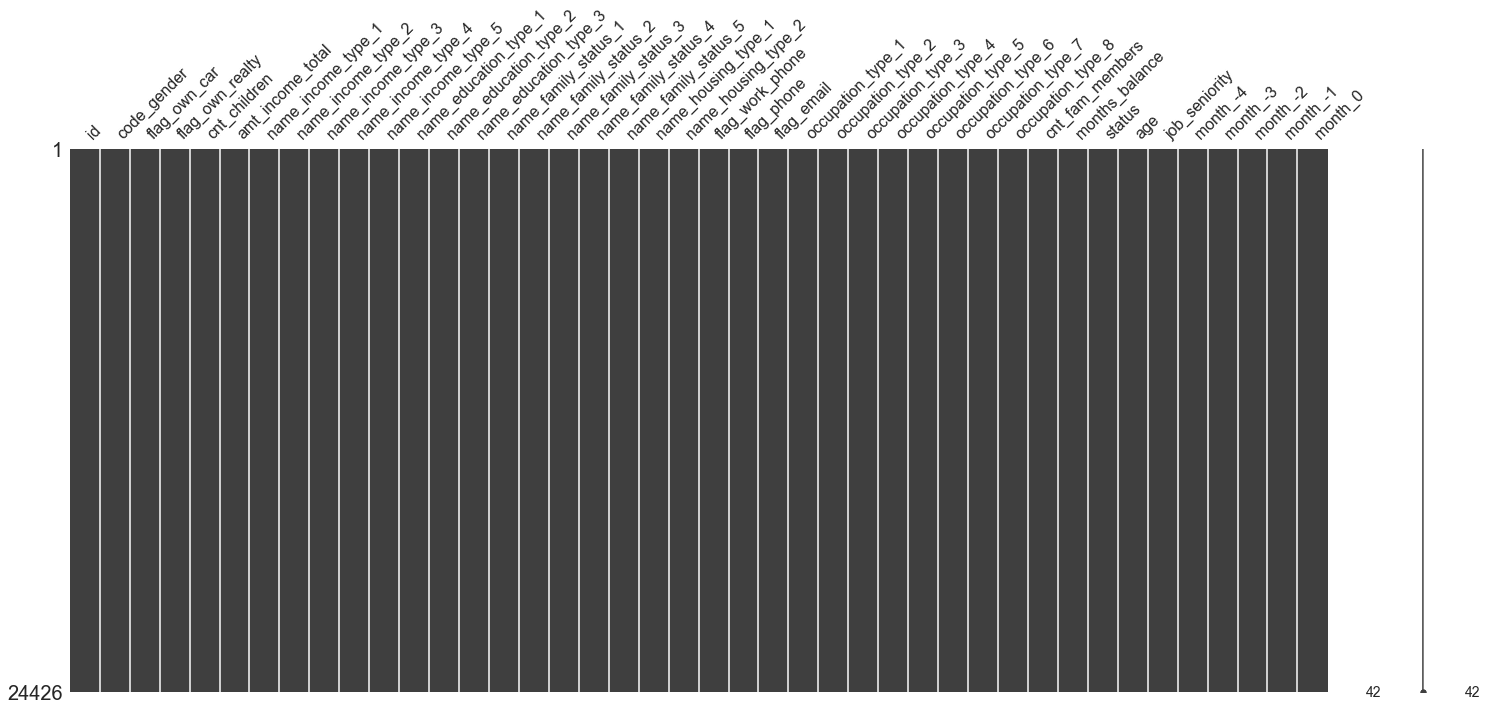

In [54]:

msno.matrix(X_train)
plt.show()

In [55]:
for col in X_train.columns:
    if X_train[col].dtypes == np.float64:
        X_train[col] = X_train[col].apply(np.int64)

## Modelling

In [56]:
X_train[col] = X_train[col].apply(np.int64)

In [59]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf = 2 )
clf.fit(X_train,y_train)
clf.p

DecisionTreeClassifier(max_depth=2, min_samples_leaf=2)

In [ ]:
int(X_train['month_-1'].iloc[])

In [ ]:
X_train['month_-1'].unique()

In [64]:
clf.predict(X_train)

array([-2,  0, -1, ..., -1, -1, -1], dtype=int64)

In [65]:
clf.get_depth()

2